# Part 4: Attention-based classification

This last part will have you _using_ the vectors we learned from your word2vec implementation to do classification. You should complete the initial word2vec part before before starting on this.

Broadly, this last part of the project consists of a few major steps:
1. Load in the data, word vectors, and word-indexing
2. Define the attention-based classification network
3. Train your model at least one epoch (2+ is recommended though).
4. Perform exploratory analyses on attention
5. Test the effects of freezing the pre-trained word vectors

After Step 2, you should be able to train your classifier implementation on a small percent of the dataset and verify that it's learning correctly. 


### Estimated performance times

We designed this project to be run on a laptop-grade CPU, so no GPU is required. If your primary computing device is a tablet or similar device, this project can also be _developed_ on that device but then run on a more powerful machine in the Great Lakes cluster (for free). Such cases are the exception though. Following, we report on the estimated times from our reference implementation for longer-running or data-intensive pieces of the project. Your timing may vary based on implementation design; major differences in time (e.g., 10x longer) usually point to a performance bug.

* Reading data, tokenizing, and converting to ids: ~20 seconds
* Training one epoch: ~18 minutes
* Training one epoch using frozen embeddings: ~3 minutes
* Evaluating on dev/test set: ~5 seconds

In [1]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

np.random.seed(42)
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init
from tqdm.auto import tqdm, trange
from collections import Counter
import random
from torch import optim
import json

import pandas as pd
import pickle

from torch.utils.tensorboard import SummaryWriter

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
import seaborn as sns

# Sort of smart tokenization
from nltk.tokenize import RegexpTokenizer

# Attention plotting
import matplotlib.pyplot as plt

# Load in the necessary parameters from the word2vec code

In [80]:
# Load the word-to-index mapping we used for word2vec and use the same type
# of tokenizer. We'll need to use this to tokenize in the same way and keep 
# the same word-to-id mapping

tokenizer = RegexpTokenizer("[\w'-]+(?<!\d)")
word_to_index = json.load(open('word-to-index.json'))
index_to_word = json.load(open('index-to-word.json'))

# Define the Classifier Model

Just like we did for word2vec, let's define a PyTorch `nn.Module` class here that will contain our classifier.

In [ ]:
class DocumentAttentionClassifier(nn.Module):
    
    def __init__(self, vocab_size, embedding_size, num_heads, embeddings_fname):
        '''
        Creates the new classifier model. embeddings_fname is a string containing the
        filename with the saved pytorch parameters (the state dict) for the Embedding
        object that should be used to initialize this class's word Embedding parameters
        '''
        super(DocumentAttentionClassifier, self).__init__()
        
        # Save the input arguments to the state
        self.vocab_size = vocab_size
        self.embedding_size = embedding_size
        self.num_heads = num_heads
        
        # Create the Embedding object that will hold our word embeddings that we
        # learned in word2vec. This embedding object should have the same size
        # as what we learned before. However, we don't to start from scratch! 
        # Once created, load the saved (word2vec-based) parameters into the object
        # using load_state_dict.
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.embedding.load_state_dict(torch.load(embeddings_fname))

        # Define the attention heads. You have two options:
        # 
        # 1) the worse way to implement this is to define your heads using an Embedding
        #    and then access them individually later in forward(). This will be slower
        #    but will probably still work 
        #
        # 2) the ideal way is to think of your attention heads as rows in a matrix--
        #    just like we do for word2vec. While this is kind of the same as how
        #    we represent things like in an Embedding, the key difference is that we
        #    can now use **matrix operations** to calculate the different r and a
        #    vectors, which will be much faster (and less code). To do this, you'll
        #    need to represent the attention heads as a Tensor directly (not a layer)
        #    and make sure pytorch runs gradient descent on these parameters.
        #
        #  It's up to you which to use, but try option 2 first and see what you do 
        #  in the forward() function
        
        self.attention_heads = nn.Parameter(torch.randn(num_heads, embedding_size))
        
        
        
        # Define the layer that goes from the concatenated attention heads' outputs
        # to the single output value. We'll push this output value through the sigmoid
        # to get our prediction

        self.fc = nn.Linear(embedding_size * num_heads, 1)
    

    def forward(self, word_ids):
        
        # Pro Tip™: when implementing this forward pass, try playing around with pytorch
        # tensors in a jupyter notebook by making "fake" versions of them. For example:
        #
        # word_embeds = torch.Tensor([[1,6,2], [9,1,7]])
        #
        # If you have two word embeddings of length 3, how can you define the attention
        # heads to get the 'r' vector? Trying things out in the simple case will let you
        # quickly verify the sequence of operations you want to run, e.g., that you can take
        # the softmax of the 'r' vector to get the 'a' vector and it has the right shape
        # and values
        
        # Hint 1: If you're representing attention using Option 2, most of this code is just 
        #         matrix multiplications

        # Hint 2: Most of your time is going to be spent figuring out shape errors and what
        #         operations you need to do to get the right outputs. This is normal.
        
        # Hint 3: This is the hardest part of this last part of the project.

        
        # Get the word embeddings for the ids
        word_embeds = self.embedding(word_ids)

        # Calcuate the 'r' vectors which are the dot product of each attention head
        # with each word embedding. You should be getting a tensor that has this
        # dot product back out---remember this vector is capturing how much the 
        # head thinks the vector is relevant for the task
        r = torch.matmul(self.attention_heads, word_embeds.transpose(1, 2))

        # Calcuate the softmax of the 'r' vector, which call 'a'. This will give us
        # a probability distribution over the tokens for each head. Be sure to check
        # that the softmax is being calculated over the right axis/dimension of the 
        # data (You should see probability values that sum to 1 for each head's 
        # ratings across all the tokens)        
        a = F.softmax(r, dim=-1)

        # Calculate the re-weighting of the word embeddings for each head's attention
        # weight and sum the reweighted sequence for each head into a single vector.
        # This should give you n_heads vectors that each have embedding_size length.
        # Note again that each head should give you a different weighting of the
        # input word embeddings

        
        # Create a single vector that has all n_heads' attention-weighted vectors
        # as one single vector. We need this one-long-vector shape so that we 
        # can pass all these vectors as input into a layer.
        #
        # NOTE: if you're doing Option 2 for representing attention, you don't 
        # actually need to create a new vector (which is very inefficient).
        # Instead, you can create a new *view* of the same data that reshapes the
        # different heads' vectors so it looks like one long vector. 
        d = torch.matmul(a, word_embeds)
        d_concat = d.reshape(-1, self.num_heads * self.embedding_size)

        # Pass the side-by-side attention-weighted vectors through your linear
        # layer to get some output activation.
        #
        # NOTE: if you're feeling adventurous, try adding an extra layer here
        # which will allow you different attention-weighted vectors to interact
        # in making the model decision
        output = self.fc(d_concat)
        
        
        # Return the sigmoid of the output activation *and* the attention 
        # weights for each head. We'll need these later for visualization
        return torch.sigmoid(output), a

# Load in the datasets 

You can keep these as pandas data frames.

In [4]:
sent_train_df = pd.read_csv('sentiment.train.csv')
sent_dev_df = pd.read_csv('sentiment.dev.csv')
sent_test_df = pd.read_csv('sentiment.test.csv')

Convert each dataset into a list of tuples of the form `([word-ids,...], label)`. Both the word ids and the label should be numpy arrays so they will get converted into Tensors by our data loader. Note that you did something very similar for creating the word2vec training data. This process will require tokenizing the data in the same way as you did for word2vec and using the same word-to-id mapping (both of which you loaded/created above).

In [72]:
train_list = [(np.array([word_to_index.get(word) for word in tokenizer.tokenize(sent_train_df['text'][i]) if word_to_index.get(word)]).astype(np.int32), np.array([sent_train_df['label'][i]]).astype(np.int32)) for i, _ in sent_train_df.iterrows()]
dev_list = [(np.array([word_to_index.get(word) for word in tokenizer.tokenize(sent_dev_df['text'][i]) if word_to_index.get(word)]).astype(np.int32), np.array([sent_dev_df['label'][i]]).astype(np.int32)) for i, _ in sent_dev_df.iterrows()]

In [130]:
test_list = [(np.array([word_to_index.get(word) for word in tokenizer.tokenize(sent_test_df['text'][i]) if word_to_index.get(word)]).astype(np.int32), np.array(sent_test_df['inst_id'][i]).astype(np.int32)) for i, _ in sent_test_df.iterrows()]

If this worked you should see XXXX train, XXXX dev, and XXX test instances.

In [73]:
len(train_list), len(dev_list), len(test_list)

(160000, 20000, 20000)

# Build the code training loop

We'll evaluate periodically so before we start training, let's define a function that takes in some evaluation data (e.g., the dev or test sets) and computes the F1 score on that data. 

In [154]:
def run_eval(model, eval_data):
    '''
    Scores the model on the evaluation data and returns the F1
    '''
    with torch.no_grad():
        
        model.eval()
        
        # Initialize the true and predicted labels
        true_labels = []
        pred_labels = []
        
        # Loop over the evaluation data in batches
        for data in eval_data:
            # Get the input data and labels
            word_ids, labels = data
            
            # Compute the predictions
            logits, _ = model(word_ids)
            predictions = torch.round(logits)
            
            # Collect the true and predicted labels
            true_labels += [label for label in labels.tolist()]
            pred_labels.append(int(predictions))
        
        # Compute the F1 score
        f1 = f1_score(true_labels, pred_labels)
        
        # Set the model back to training mode
        model.train()
        
        # Return the F1 score
        return f1

In [142]:
def run_test(model, test_data):
    '''
    test data
    '''
    with torch.no_grad():
        
        model.eval()
        
        pred_labels = []
        
        for data in test_data:
            word_ids, inst_ids = data
            
            # Compute the predictions
            logits, _ = model(word_ids)
            predictions = torch.round(logits)
            
            pred_labels.append(int(predictions))
        
        model.train()
        
        # Return the F1 score
        return pred_labels

Now that you have data in the right format and a neural network designed, it's time to train the network and see if it's all working. The training code will look surprisingly similar to your word2vec code. 

For all steps, be sure to use the hyperparameters values described in the write-up.

1. Initialize your optimizer and loss function 
2. Create your network
3. Load your dataset into PyTorch's `DataLoader` class, which will take care of batching and shuffling for us (yay!)
4. **see below:** Create a new `SummaryWriter` to periodically write our running-sum of the loss to a tensorboard
5. Train your model 

For step 4, in addition to writing the loss, you should write the F1 score on the dev set to the writer as well, using the specified number of steps.

**NOTE:** In this training, you'll use a batch size of 1, which will make your life _much_ simpler.

In [179]:
# set hyperparameters
embedding_size = 50
lr = 0.0008
num_epochs = 1
batch_size = 1
vocab_size = len(word_to_index) - 1

# create your network and initialize your optimizer and loss function 
model = DocumentAttentionClassifier(vocab_size, embedding_size, 4, 'target_embedding_weights.pth')
optimizer = optim.AdamW(model.parameters(), lr=lr)
loss_fn = nn.BCELoss()

# Start tensorboard
writer = SummaryWriter('attention log')
eva_data = DataLoader(dev_list, batch_size=batch_size)

# HINT: wrapping the epoch/step loops in nested tqdm calls is a great way
# to keep track of how fast things are and how much longer training will take

for epoch in range(num_epochs):

    loss_sum = 0
    data_loader = DataLoader(train_list, batch_size=batch_size, shuffle=True)

    for step, data in enumerate(tqdm(data_loader)):
        word_ids, label = data   

        optimizer.zero_grad()

        output, _ = model(word_ids)
        #print(f'{output}, {label}')
        loss = loss_fn(output, label.float())

        loss.backward()
        optimizer.step()
 
        loss_sum += loss.item()

        if (step + 1) % 500 == 0:
            # log train loss to tensorboard
            writer.add_scalar('loss/train', loss_sum, epoch * len(data_loader) + step)
            # evaluate on eval_data
            f1 = run_eval(model, eva_data)

            # log loss and f1 to tensorboard
            writer.add_scalar('f1/train', f1, epoch * len(data_loader) + step)

            loss_sum = 0
        
        if step > 160000:
            print('Reached max number of steps, stopping early.')
            break

    print(f'Epoch {epoch+1} - F1: {f1:.4f}')
        
        

# once you finish training, it's good practice to switch to eval.
model.eval()
writer.close()

  0%|          | 0/160000 [00:00<?, ?it/s]

Epoch 1 - F1: 0.8605


In [183]:
test_data = DataLoader(test_list, batch_size=batch_size)
pred_table = run_test(model, test_data)

In [184]:
header = ['inst_id', 'prediction']

data = []

count = 0
for i, prediction in enumerate(pred_table):
    data.append([i, prediction])

In [185]:
import csv

with open('sentiment.submission.example.word2vec_1.csv', 'w', encoding='UTF8', newline='') as f:
    writer = csv.writer(f)

    # write the header
    writer.writerow(header)

    # write multiple rows
    writer.writerows(data)

#### p19 Freezing Vectors

In [233]:
# Freeze the embedding layer
num_epochs = 3
model = DocumentAttentionClassifier(vocab_size, embedding_size, 4, 'target_embedding_weights.pth')
model.embedding.weight.requires_grad = False

optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)

writer = SummaryWriter('freezing vector log')

for epoch in range(num_epochs):

    loss_sum = 0
    data_loader = DataLoader(train_list, batch_size=batch_size, shuffle=True)

    for step, data in enumerate(tqdm(data_loader)):
        word_ids, label = data   

        optimizer.zero_grad()

        output, _ = model(word_ids)
        #print(f'{output}, {label}')
        loss = loss_fn(output, label.float())

        loss.backward()
        optimizer.step()
 
        loss_sum += loss.item()

        if (step + 1) % 500 == 0:
            # log train loss to tensorboard
            writer.add_scalar('loss/freezing train', loss_sum, epoch * len(data_loader) + step)
            
            loss_sum = 0
        
        if step > 145000:
            print('Reached max number of steps, stopping early.')
            break

model.eval()
writer.close()

  0%|          | 0/160000 [00:00<?, ?it/s]

Reached max number of steps, stopping early.


  0%|          | 0/160000 [00:00<?, ?it/s]

Reached max number of steps, stopping early.


  0%|          | 0/160000 [00:00<?, ?it/s]

Reached max number of steps, stopping early.


# Inspecting what the model learned

In this last bit of the project you should look at the model's attention weights. We've written a visualization helper function below that will plot the attention weights. You'll need to fill in the `get_label_and_weights` method that uses the model to classify some new text and structures the attention output in a way that's specified. 

**NOTE:** most of the code for `get_label_and_weights` is code you've already written above.

In [188]:
def get_label_and_weights(text):
    '''
    Classifies the text (requires tokenizing, etc.) and returns (1) the classification label, 
    (2) the tokenized words in the model's vocabulary, 
    and (3) the attention weights over the in-vocab tokens as a numpy array. Note that the
    attention weights will be a matrix, depending on how many heads were used in training.
    '''
    with torch.no_grad():
        # Tokenize the text
        tokens = tokenizer.tokenize(text)
        words = [word for word in tokens if word_to_index.get(word)]

        # Get the token IDs and the attention mask
        word_ids = np.array([word_to_index.get(word) for word in words]).astype(np.int32)
        word_ids = torch.tensor(word_ids).unsqueeze(0)

        outputs = model(word_ids)

        # Get the predicted label
        predicted_label = torch.argmax(outputs[0]).item()

        # Get the attention weights from the last layer of the model
        attention = outputs[-1][-1].detach().numpy()

    return predicted_label, words, attention

### Helper functions for visualization

In [197]:
def visualize_attention(words, attention_weights):
    '''
    Makes a heatmap figure that visualizes the attention weights for an item.
    Attention weights should be a numpy array that has the shape (num_words, num_heads)
    '''
    fig, ax = plt.subplots() 
    # Rescale image size based on the input length
    fig.set_size_inches((len(words), 4))    
    im = ax.imshow(attention_weights)

    head_labels = [ 'head-%d' % h for h in range(attention_weights.shape[0])]
    ax.set_xticks(np.arange(len(words))) # , labels=words)
    ax.set_yticks(np.arange(len(head_labels))) #, labels=head_labels)

    # Rotate the word labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    
    # Add the words and axis labels
    ax.set_yticklabels(labels=range(attention_weights.shape[0]), fontsize=16)
    ax.set_ylabel('Attention Head', fontsize=16)
    ax.set_xticklabels(labels=words, fontsize=16)

    # Add a color bar to show probability scaling
    cb = fig.colorbar(im, ax=ax, label='Probability', pad = 0.01)
    cb.ax.tick_params(labelsize=16)
    cb.set_label(label='Probability',size=16)
    fig.tight_layout()
    plt.show()

#### P21.1 Four attention plots from text in the dev data

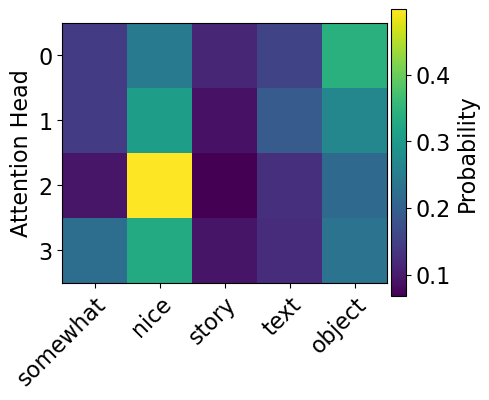

In [217]:
a1 = sent_dev_df[sent_dev_df['label'] == 0].text.sample(n=1)
pred, tokens, attn = get_label_and_weights(str(a1))
visualize_attention(tokens, attn)

10718    The 1956 first edition of this book was the fi...
Name: text, dtype: object


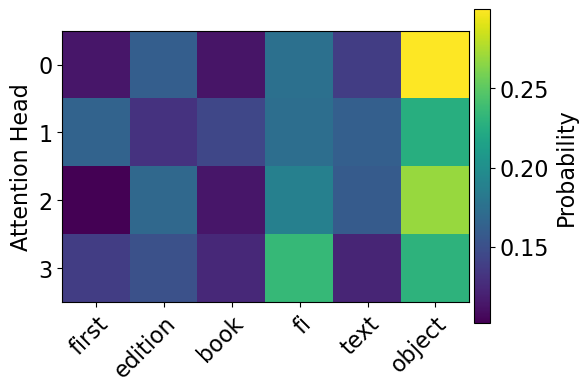

In [215]:
# label 0
a2 = sent_dev_df.iloc[:, 0].sample(n=1)
pred, tokens, attn = get_label_and_weights(str(a2))
visualize_attention(tokens, attn)

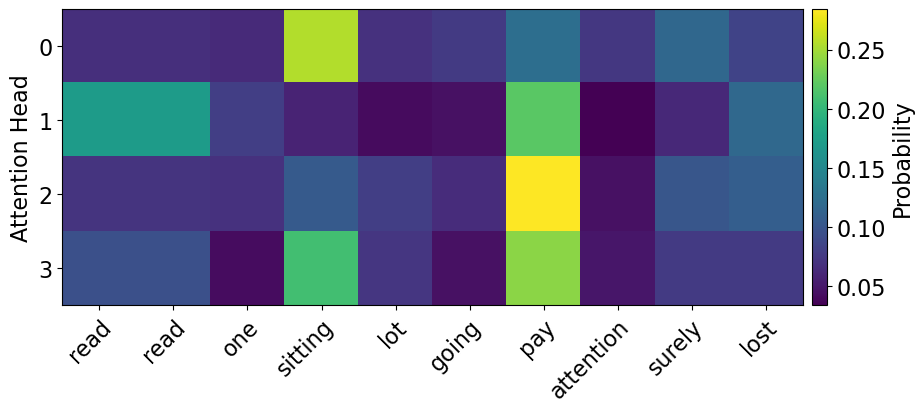

In [205]:
# label 1
a3 = 'Good read, read it all in one sitting. A lot going on so pay attention or you will surely be lost.'
pred, tokens, attn = get_label_and_weights(a3)
visualize_attention(tokens, attn)

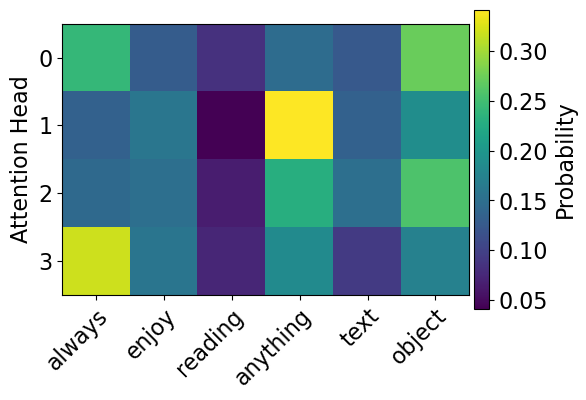

In [227]:
a4 = sent_dev_df[sent_dev_df['label'] == 1].text.sample(n=1)
pred, tokens, attn = get_label_and_weights(str(a4))
visualize_attention(tokens, attn)

#### p21.2
As observed from the visualizations, I guess different attention heads in the model is focusing on different aspects of the input sequence. Some heads seem to focus on certain parts of speech, such as proper nouns or adjectives, while others seem to be looking for specific phrases or patterns in the text. Additionally, some heads seem to be looking at the beginning of the sentence, while others focus on the end or the middle.

There are also some patterns that emerge when looking at multiple examples. For instance, The third attention head appears to be more biased towards extreme values (0 and 1). Therefore, the results it presents show that compared to other attention heads, its analysis of words tends to be more polarized; Moerover, the first attention heads appear to be more sensitive to negations or the presence of verbs. 

#### P21.3
In this case, I wrote a misleading sentence that concludes the neagetive phrase "rock bottom", however the sentence is actually expressing a positive sentiment. And we can see from the visulization, these words tend to 0 according to the classifier's result.

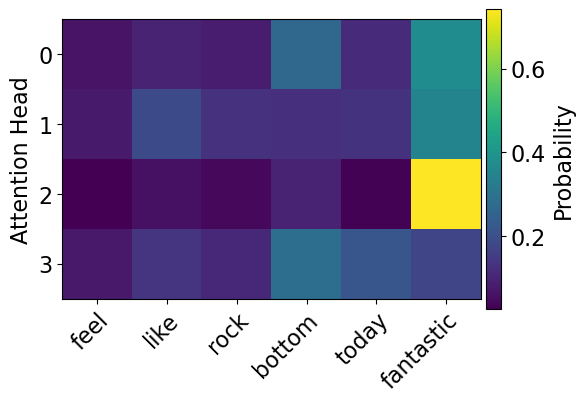

In [228]:
mislead_exa = "I feel like I'm at rock bottom today, which is fantastic!"
pred, tokens, attn = get_label_and_weights(mislead_exa)
visualize_attention(tokens, attn)

# Optional TODOs:

### How many instances do we need to learn?

Since the word2vec vectors capture word meaning, do we need to see a lot of examples to train an effective classifier? Maybe we can get away with fewer (or not?). Try making a plot that shows the performance of training on 1 epoch with varying numbers of training examples. What if we just had 10 examples? 100? 1000? 

### Add more layers to the network

This is the second easiest one, but can be fun. What if you add more layers after you aggregate? Does letting the different attention heads' representations interact give better performance? Find out!

### Change the learning rate dynamically

We have a fixed learning rate, but what if we wanted to decrease the learning rate as the model starts to converge? In many cases, this can help the model take smaller but more precise steps towards the best possible parameters. PyTorch supports this with _learning rate schedulers_ that tell pytorch how and when to change the learning rate. See if you can get a better performance using a scheduler!

### Add support for batch sizes > 1

This is non-trivial but will increase training speed _a lot_. The main issue with increasing batch sizes is that our input sequences (the word ids) in a batch will have different lengths. Under the hood, pytorch is turning your code into a series of very fast matrix operations. However, if those matrices suddenly have difference sizes, the math no longer works. As a result developers (like us) have to do a few things:

* We need to _pad_ the sequences with empty values so that all sequences have the same length. You could do this by  adding an extra word ID that is the "empty token" and make sure its values are set to 0 (so it won't interact with anything)

* Set up a collate function in our DataLoader that automatically pads each batch's data based on the longest length in the batch

* At inference time, it's also efficient to mask part of the sequence that's the padded part so we ignore the computations for that part in anything downstream. Depending on how you set it up, you may be able to avoid this step.

If you want to dig into this, you might see some of the documentation around packed and padded sequences in pytorch. You won't need to use these functions but they can provide more context for what's happening and why.


### Add positional information to the word embeddings

Right now our model doesn't know much about which order the words are in. What if we helped the model in this? One way that people have done this is to _add_ some positional embedding to the word embedding, where the positional embedding represents which position in the sequence is in. There are many complicated schemes for this, but one potential idea is to _learn the positional embeddings_. You would keep a separate `Embedding` object for positions with the number of positions up to the length of your longest sequence in the data. Then for the word in the first position, you add `position_embeddings(0)` to it. You can definitely speed that up by passing in a sequence of the positions in the current input and, conveniently, pytorch will let you easily add all the position embeddings to the word embeddings easily (no for loop required).

Will it help here? I have no idea but I'm curious.


**No extra credit is given for these; they're just for folks who want to explore more**